In [38]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pandas as pd
from utilidades import load_data,get_mean_af
from sklearn.cluster import KMeans
from functools import reduce
from sklearn.metrics import silhouette_score

In [39]:
# GAP Statistic function
def compute_inertia(a, X):
    from sklearn.metrics import pairwise_distances
    W = [np.mean(pairwise_distances(X[a == c, :])) for c in np.unique(a)]
    return np.mean(W)

def compute_gap(clustering, data, k_max=5, n_references=5):
    if len(data.shape) == 1:
        data = data.reshape(-1, 1)
    reference = np.random.rand(*data.shape)
    reference_inertia = []
    for k in range(1, k_max+1):
        local_inertia = []
        for _ in range(n_references):
            clustering.n_clusters = k
            assignments = clustering.fit_predict(reference)
            local_inertia.append(compute_inertia(assignments, reference))
        reference_inertia.append(np.mean(local_inertia))
    
    ondata_inertia = []
    for k in range(1, k_max+1):
        clustering.n_clusters = k
        assignments = clustering.fit_predict(data)
        ondata_inertia.append(compute_inertia(assignments, data))
        
    gap = np.log(reference_inertia)-np.log(ondata_inertia)
    return gap, np.log(reference_inertia), np.log(ondata_inertia)

In [40]:
afs=load_data()

Using all features

In [41]:
antifs=[]
for name, antif in afs.items():
    antif.columns = ['country','date','af_in_pr_'+name[2:],'af_in_vl'+name[2:],'af_ex_pr'+name[2:],'af_ex_vl'+name[2:], 'af_in_pr2'+name[2:],
                    'af_in_pr2'+name[2:], 'af_ex_pr2'+name[2:],'af_ex_vl2'+name[2:]]
    antifs.append(antif)

In [42]:
result=reduce(lambda df1,df2: df1.merge(df2,how='inner',on=['country','date']),antifs)

In [43]:
result=result.dropna(axis=0)

In [44]:
_A=result.groupby(['country']).mean().drop(columns='date')

In [45]:
_A = _A.dropna()

In [46]:
_A.head()

,af_in_pr_cal,af_in_vlcal,af_ex_prcal,af_ex_vlcal,af_in_pr2cal,af_in_pr2cal,af_ex_pr2cal,af_ex_vl2cal,af_in_pr_gdp,af_in_vlgdp,...,af_ex_pr2pop,af_ex_vl2pop,af_in_pr__ye,af_in_vl_ye,af_ex_pr_ye,af_ex_vl_ye,af_in_pr2_ye,af_in_pr2_ye,af_ex_pr2_ye,af_ex_vl2_ye
country,,,,,,,,,,,,,,,,,,,,,
Albania,-0.026102,-0.035248,0.182917,0.076113,-0.019201,-0.043655,0.141378,0.104818,-0.079464,-0.070233,...,0.136287,0.091113,-0.026102,-0.035248,0.182917,0.076113,-0.019201,-0.043655,0.141378,0.104818
Algeria,-0.037994,-0.001134,-0.270652,-0.173004,-0.035886,0.002964,-0.221498,-0.250180,-0.042080,-0.010242,...,-0.233450,-0.246385,-0.037994,-0.001134,-0.270652,-0.173004,-0.035886,0.002964,-0.221498,-0.250180
Antigua and Barbuda,-0.146845,-0.029541,-0.117445,-0.038269,-0.117734,-0.039245,-0.088445,-0.055466,0.026909,-0.036897,...,-0.068902,-0.042696,-0.146845,-0.029541,-0.117445,-0.038269,-0.117734,-0.039245,-0.088445,-0.055466
Argentina,0.033498,0.023616,0.006506,0.012282,0.036114,0.021479,0.007677,0.011215,0.013221,0.015384,...,0.015989,0.013473,0.033498,0.023616,0.006506,0.012282,0.036114,0.021479,0.007677,0.011215
Armenia,0.035473,0.063038,0.077354,0.013448,0.034486,0.074095,0.051765,0.044378,0.052256,0.043796,...,0.089059,0.075189,0.035473,0.063038,0.077354,0.013448,0.034486,0.074095,0.051765,0.044378


In [62]:
_A=_A.iloc[:,-8:]

In [63]:
RANDOM_STATE=1

### PCA

In [64]:
pca = PCA(n_components=2,random_state=RANDOM_STATE).fit(_A)
_A_projected=pca.transform(_A)

In [65]:
np.cumsum(pca.explained_variance_ratio_)

array([0.79084792, 0.91550277])

In [66]:
pca.n_components_

2

<AxesSubplot:>

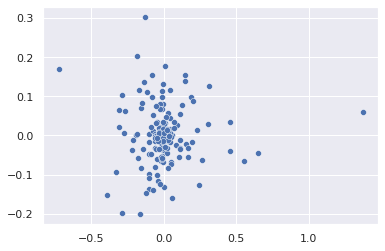

In [67]:
sns.scatterplot(x=_A_projected[:,0],y=_A_projected[:,1])

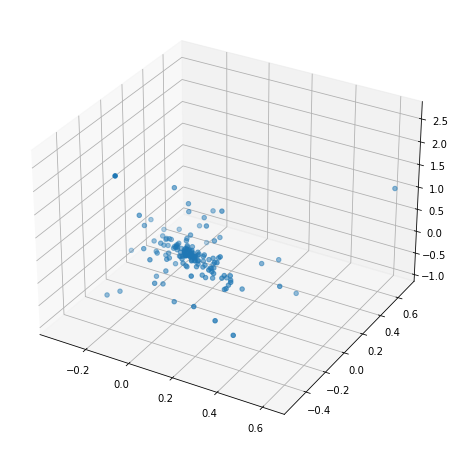

In [41]:
plt.figure(figsize=(10,8))
ax = plt.axes(projection='3d')
# Data for three-dimensional scattered points
zdata = _A_projected[:,0]
xdata = _A_projected[:,1]
ydata = _A_projected[:,2]
ax.scatter3D(xdata, ydata, zdata)

### GAP Statistic --- Estimating number of clusters

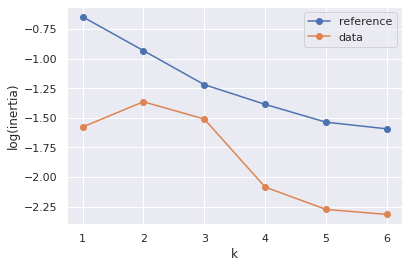

Text(0.5, 0, 'k')

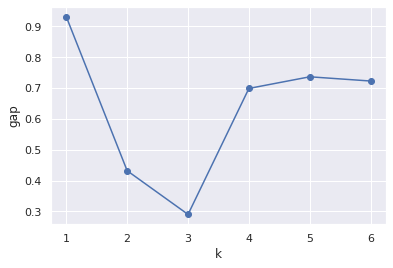

In [68]:
k_max = 6
gap, reference_inertia, ondata_inertia = compute_gap(KMeans(random_state=RANDOM_STATE,n_init=100), _A_projected, k_max)


plt.plot(range(1, k_max+1), reference_inertia,
         '-o', label='reference')
plt.plot(range(1, k_max+1), ondata_inertia,
         '-o', label='data')
plt.xlabel('k')
plt.ylabel('log(inertia)')
plt.legend()
plt.show()

plt.plot(range(1, k_max+1), gap, '-o')
plt.ylabel('gap')
plt.xlabel('k')

## KMeans

In [69]:
cluster = KMeans(n_clusters=4,random_state=RANDOM_STATE,n_init=100).fit(_A_projected)
ys=cluster.labels_

grupos_km = pd.DataFrame({'country':_A.index.values,'grupo':ys})

In [70]:
# grupos_km.pivot(columns='grupo').to_excel('~/ver_clusters_v2.xlsx')

In [71]:
grupos_km=grupos_km.set_index('country')

<AxesSubplot:xlabel='grupo'>

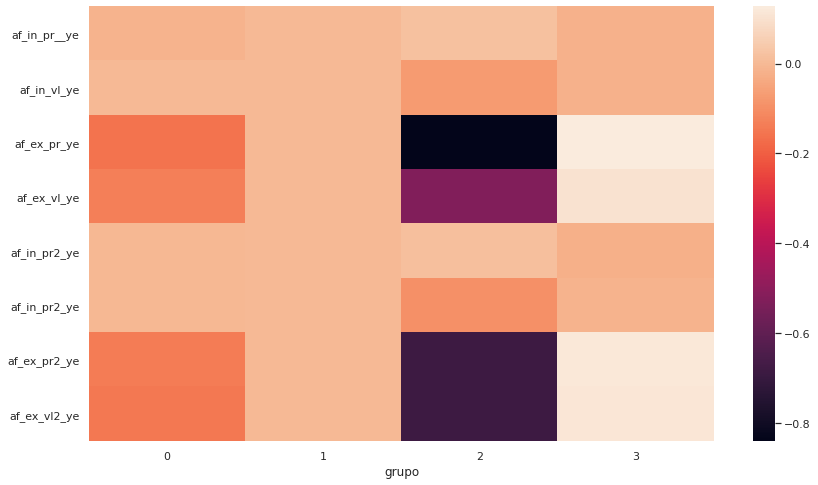

In [72]:
plt.figure(figsize=(14,8))
sns.heatmap(_A.join(grupos_km).groupby('grupo').mean().T)

In [73]:
grupos_km[grupos_km['grupo']==3]

,grupo
country,
Albania,3
Azerbaijan,3
"Bahamas, The",3
Belize,3
Burkina Faso,3
Burundi,3
Djibouti,3
Fiji,3
French Guiana,3
